In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE

In [2]:
# plot 5x6 histograms for each variable in the dataset
def plot_hist(data, title):
    # plot 5x6 histogram of all variables
    fig, axs = plt.subplots(5, 6, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.hist(data.iloc[:, i])
        ax.set_title(data.columns[i])
    plt.savefig('images/'+title+'.png')

# Preparation

In [113]:
# load exaggerate dataset
exaggerate = pd.read_csv('./data/working_sheet.csv', sep=";")
target='death_aecopd' # aecopd_12m
# rename variables for more practical handling
exaggerate = exaggerate.rename(columns={'sex': 'gender', 'dyspnoea_mMRC': 'mmrc', 'ami':'myocardial_infarct', 'cbd':'stroke', 'dyspnoea_yesno':'dyspnoea', target:'target'})
relevant_vars=exaggerate.columns
# ['gender', 'age', 'bmi', 'sbp', 'dbp', 'diabetes', 'heart_failure', 'temperature',  'dyspnoea', 'mmrc', 'target', ] #'cancer', 'rr', 'myocardial_infarct', 'stroke','prev_exacerb'

# drop irrelevant variables
exaggerate = exaggerate[relevant_vars]

# sort columns
exaggerate = exaggerate.reindex(sorted(exaggerate.columns), axis=1)

# correct bmi scale.

# if bmi is between 100 and 1000, then divide by 10 to get the correct scale
exaggerate.loc[(exaggerate['bmi'] > 100) & (exaggerate['bmi'] < 1000), 'bmi'] = exaggerate['bmi'] / 10
# if bmi is betweeen 1000 and 10000 then divide by 100 to get the correct scale
exaggerate.loc[(exaggerate['bmi'] > 1000) & (exaggerate['bmi'] < 10000), 'bmi'] = exaggerate['bmi'] / 100

# correct the temperature scale (if temperature is between 100 and 1000, then divide by 10 to get the correct scale)
exaggerate.loc[(exaggerate['temperature'] > 100) & (exaggerate['temperature'] < 1000), 'temperature'] = exaggerate['temperature'] / 10

# create fever variable
exaggerate['fever'] = 0
# according to CDC, john hopkins etc. fever is defined as a temperature of 38 degrees or higher
exaggerate.loc[exaggerate['temperature'] > 38, 'fever'] = 1
exaggerate = exaggerate.drop(columns=['temperature'])

# if prev_exacerb is 1 or above then set it to 1 else 0
# exaggerate.loc[exaggerate['prev_exacerb'] >= 1, 'prev_exacerb'] = 1

# # create fast_breathing variable
# exaggerate['fast_breathing'] = 0
# # clinically normal respiratory rate is 12 - 20 anything above is considered fast breathing for adults
# exaggerate.loc[exaggerate['rr'] > 20, 'fast_breathing'] = 1
# exaggerate = exaggerate.drop(columns=['rr'])

# plot_hist(exaggerate)

########
# Missing values
########

# drop fev1
exaggerate = exaggerate.drop(columns=['fev1', 'retractions', 'rr', 'oedema', 'death'])



# print(exaggerate.shape)
# drop rows with more than 85% missing values
exaggerate = exaggerate.dropna(thresh=0.70*exaggerate.shape[1], axis=0)

# drop all rows where mmrc is missing
# exaggerate = exaggerate.dropna(subset=['mmrc'], axis=0)

# reset index to be sequential again
exaggerate = exaggerate.reset_index(drop=True)
# print(exaggerate.shape)

# print missing values in a table for each variable
# print("missing values in the dataset: ")
# print(exaggerate.isna().sum())


# impute mmrc values using median and store it for later
# mmrc = exaggerate['mmrc'].fillna(exaggerate['mmrc'].median())

# imputer = IterativeImputer(random_state=42)
# imputed = imputer.fit_transform(exaggerate)
# exaggerate = pd.DataFrame(imputed, columns=exaggerate.columns)


# plot 2x5 histograms for each variable


# print missing values in a table for each variable
# print("missing values in the dataset after: ")
# print(exaggerate.isna().sum())

numeric_vars = ['age', 'bmi', 'sbp', 'dbp', 'saturation', 'hr']
for var in numeric_vars:
    exaggerate[var] = exaggerate[var].fillna(exaggerate[var].median())

categorical_vars = ['confusion', 'gender', 'diabetes', 'heart_failure', 'mmrc', 'target', 'fever',   'dyspnoea', ] # cancer, 'fast_breathing', 'myocardial_infarct','stroke','prev_exacerb'
for var in categorical_vars:
    exaggerate[var] = exaggerate[var].fillna(exaggerate[var].mode()[0])


# plot_hist(exaggerate)

#########
# Outliers
#########

# dealing with outliers is not necessary in this dataset

########
# Feature Engineering
########

# create a new variable for hypertension. If sbp variable is greater than 140 or dbp variable is greater than 90, then hypertension is 1, otherwise 0
exaggerate['hypertension'] = 0
exaggerate.loc[(exaggerate['sbp'] > 140) | (exaggerate['dbp'] > 90), 'hypertension'] = 1

# drop sbp and dbp columns
exaggerate = exaggerate.drop(columns=['sbp', 'dbp'])

# drop mmrc column for now
# exaggerate = exaggerate.drop(columns=['mmrc'])

#Cardiovascular disease was defined as heart failure, acute myocardial infarction, cerebrovascular disease, or peripheral arterial disease


##########
# Normalization
##########



numeric_vars = ['age', 'bmi', 'mmrc', 'saturation', 'hr']
df_nr = exaggerate[numeric_vars]
df_rest = exaggerate.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=exaggerate.index, columns=numeric_vars)
exaggerate= concat([tmp, df_rest], axis=1)

############
# Target variable
############

# Binarize the target variable if data in target column is above 0, then set it to 1 else 0
# print("target variable value counts: ")
# print(exaggerate['target'].value_counts())
exaggerate.loc[exaggerate['target'] > 0, 'target'] = 1


# convert target to 4 classes like in harvard dataset
# exaggerate_data.loc[(exaggerate_data['target'] > 1) & (exaggerate_data['target'] <= 5), 'target'] = 2
# exaggerate_data.loc[(exaggerate_data['target'] > 5) & (exaggerate_data['target'] <= 10), 'target'] = 3
# exaggerate_data.loc[(exaggerate_data['target'] > 10), 'target'] = 4
# # add one to all target classes
# exaggerate_data['target'] = exaggerate_data['target'] + 1

exaggerate = exaggerate.reindex(sorted(exaggerate.columns), axis=1)
# exaggerate.to_csv('exaggerate/data/imputed_hypertension.csv', index=False, sep=';')


# print(exaggerate['target'].value_counts())

# get rid of any nan values in the dataset
# exaggerate = exaggerate.dropna()

# print exaggerate missing values
# print("missing values in the dataset: ")
print(exaggerate.isna().sum())
# use smote to rebalance the exaggerate dataset in place

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(exaggerate.drop(columns=['target']), exaggerate['target'])
X_res['target'] = y_res
exaggerate = X_res

# undersampling

# # get number of underrespresented class 0
# u = exaggerate['target'].value_counts().min()
# u_label = exaggerate['target'].value_counts().idxmin()

# # overrepresented class 1
# o = exaggerate['target'].value_counts().max()
# o_label = exaggerate['target'].value_counts().idxmax()

# # add all underrepresented samples to a new dataframe
# underrepresented = exaggerate[exaggerate['target'] == u_label]
# # sample u number of overrepresented samples from the dataset
# overrepresented = exaggerate[exaggerate['target'] == o_label].sample(n=u, random_state=42)
# # concatenate underrepresented and overrepresented
# exaggerate = pd.concat([underrepresented, overrepresented])



# print(X_res['target'].value_counts())

# print(exaggerate.head())
# plot_hist(exaggerate)

# TODO there is something wrong with target value distribution

# save the new dataset
# exaggerate.to_csv('exaggerate/data/harvard_cv.csv', index=False, sep=';')

aecopd_12m            0
age                   0
bmi                   0
cancer                0
charlson              0
confusion             0
dementia              0
diabetes              0
dyspnoea              0
fever                 0
gender                0
heart_failure         0
home_care             0
hr                    0
hypertension          0
mmrc                  0
myocardial_infarct    0
pad                   0
rural                 0
saturation            0
season                0
stroke                0
target                0
dtype: int64


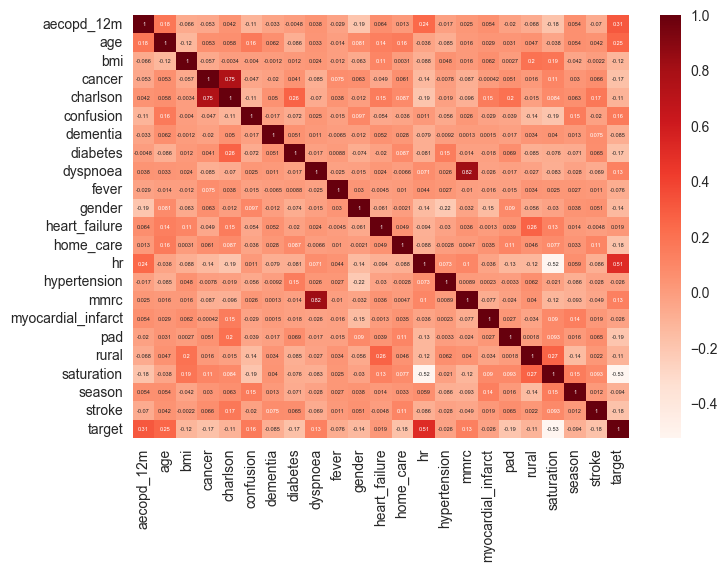

In [94]:
import seaborn as sns
# plot correlation matrix using seaborn
corr = exaggerate.corr()
# make font really small
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds, annot_kws={"size": 4})
plt.show()

In [18]:
# # load exaggerate dataset
# exaggerate = pd.read_csv('data/working_sheet.csv', sep=";")
# target='aecopd_12m'
# # rename variables for more practical handling
# exaggerate = exaggerate.rename(columns={target:'target', 'sex':'gender', 'dyspnoea_mMRC':'mmrc'})

# # drop irrelevant variables
# exaggerate = exaggerate.drop(columns=['fev1', 'death', 'death_aecopd'])
# print(exaggerate.columns)

# # sort columns
# exaggerate = exaggerate.reindex(sorted(exaggerate.columns), axis=1)

# # correct bmi scale.
# # if bmi is between 100 and 1000, then divide by 10 to get the correct scale
# exaggerate.loc[(exaggerate['bmi'] > 100) & (exaggerate['bmi'] < 1000), 'bmi'] = exaggerate['bmi'] / 10
# # if bmi is betweeen 1000 and 10000 then divide by 100 to get the correct scale
# exaggerate.loc[(exaggerate['bmi'] > 1000) & (exaggerate['bmi'] < 10000), 'bmi'] = exaggerate['bmi'] / 100

# # correct the temperature scale (if temperature is between 100 and 1000, then divide by 10 to get the correct scale)
# exaggerate.loc[(exaggerate['temperature'] > 100) & (exaggerate['temperature'] < 1000), 'temperature'] = exaggerate['temperature'] / 10

# # plot_hist(exaggerate, 'original')

# ########
# # Missing values
# ########

# # print missing values in a table for each variable
# # print("missing values in the dataset: ")
# # print(exaggerate.isna().sum())

# print(exaggerate.shape)
# # drop rows with more than 85% missing values
# threshold = 0.75 * exaggerate.shape[1]
# exaggerate = exaggerate.dropna(thresh=threshold, axis=0)
# print(exaggerate.shape)
# print("missing values in the dataset after: ")
# print(exaggerate.isna().sum())

# # plot_hist(exaggerate, 'missing_values')

# # # drop all rows where mmrc is missing
# # # exaggerate = exaggerate.dropna(subset=['mmrc'], axis=0)

# # # reset index to be sequential again
# # exaggerate = exaggerate.reset_index(drop=True)
# # # print(exaggerate.shape)

# # # print missing values in a table for each variable
# # # print("missing values in the dataset: ")
# # # print(exaggerate.isna().sum())


# # # impute mmrc values using median and store it for later
# # # mmrc = exaggerate['mmrc'].fillna(exaggerate['mmrc'].median())

# # # imputer = IterativeImputer(random_state=42)
# # # imputed = imputer.fit_transform(exaggerate)
# # # exaggerate = pd.DataFrame(imputed, columns=exaggerate.columns)


# # # plot 2x5 histograms for each variable


# # print missing values in a table for each variable
# # print("missing values in the dataset after: ")
# # print(exaggerate.isna().sum())

# numeric_vars = ['age', 'bmi', 'sbp', 'dbp']
# for var in numeric_vars:
#     exaggerate[var] = exaggerate[var].fillna(exaggerate[var].median())

# categorical_vars = ['gender', 'cancer', 'diabetes', 'heart_failure', 'mmrc', 'target',  'stroke', 'dyspnoea'] # 'fever', 'fast_breathing', 'myocardial_infarct',
# for var in categorical_vars:
#     exaggerate[var] = exaggerate[var].fillna(exaggerate[var].mode()[0])


# # # plot_hist(exaggerate)

# # #########
# # # Outliers
# # #########

# # # dealing with outliers is not necessary in this dataset

# ########
# # Feature Engineering
# ########

# # create a new variable for hypertension. If sbp variable is greater than 140 or dbp variable is greater than 90, then hypertension is 1, otherwise 0
# exaggerate['hypertension'] = 0
# exaggerate.loc[(exaggerate['sbp'] > 140) | (exaggerate['dbp'] > 90), 'hypertension'] = 1

# # # drop sbp and dbp columns
# exaggerate = exaggerate.drop(columns=['sbp', 'dbp'])

# # # drop mmrc column for now
# # exaggerate = exaggerate.drop(columns=['mmrc'])

# # #Cardiovascular disease was defined as heart failure, acute myocardial infarction, cerebrovascular disease, or peripheral arterial disease


# # ##########
# # # Normalization
# # ##########



# numeric_vars = ['age', 'bmi', 'mmrc']
# df_nr = exaggerate[numeric_vars]
# df_rest = exaggerate.drop(columns=numeric_vars)
# transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
# tmp = DataFrame(transf.transform(df_nr), index=exaggerate.index, columns=numeric_vars)
# exaggerate= concat([tmp, df_rest], axis=1)

# # ############
# # # Target variable
# # ############

# # Binarize the target variable if data in target column is above 0, then set it to 1 else 0
# # print("target variable value counts: ")
# # print(exaggerate['target'].value_counts())
# exaggerate.loc[exaggerate['target'] > 0, 'target'] = 1


# # convert target to 4 classes like in harvard dataset
# # exaggerate_data.loc[(exaggerate_data['target'] > 1) & (exaggerate_data['target'] <= 5), 'target'] = 2
# # exaggerate_data.loc[(exaggerate_data['target'] > 5) & (exaggerate_data['target'] <= 10), 'target'] = 3
# # exaggerate_data.loc[(exaggerate_data['target'] > 10), 'target'] = 4
# # # add one to all target classes
# # exaggerate_data['target'] = exaggerate_data['target'] + 1

# # exaggerate = exaggerate.reindex(sorted(exaggerate.columns), axis=1)
# # exaggerate.to_csv('exaggerate/data/imputed_hypertension.csv', index=False, sep=';')


# # # print(exaggerate['target'].value_counts())

# # # get rid of any nan values in the dataset
# exaggerate = exaggerate.dropna()

# # use smote to rebalance the exaggerate dataset in place
# # print("perform smote")
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(exaggerate.drop(columns=['target']), exaggerate['target'])
# X_res['target'] = y_res
# exaggerate = X_res


# # # print(X_res['target'].value_counts())


# # # plot_hist(exaggerate)

# # # TODO there is something wrong with target value distribution

# # # save the new dataset
# # exaggerate.to_csv('exaggerate/data/harvard_cv.csv', index=False, sep=';')

Index(['gender', 'season', 'target', 'saturation', 'rr', 'sbp', 'dbp', 'hr',
       'temperature', 'oedema', 'retractions', 'confusion', 'dyspnoea_yesno',
       'mmrc', 'age', 'bmi', 'rural', 'home_care', 'charlson', 'ami',
       'heart_failure', 'cbd', 'pad', 'dementia', 'diabetes', 'cancer'],
      dtype='object')
(1696, 26)
(402, 26)
missing values in the dataset after: 
age                 0
ami                 0
bmi               128
cancer              0
cbd                 0
charlson            0
confusion          17
dbp                96
dementia            0
diabetes            0
dyspnoea_yesno     91
gender              0
heart_failure       0
home_care           0
hr                 43
mmrc              224
oedema            194
pad                 0
retractions       301
rr                321
rural               0
saturation         27
sbp                96
season              0
target              0
temperature       210
dtype: int64


KeyError: 'stroke'

In [4]:



# data was edited by hand before
# id column was dropped
# sex was converted to numeric: M=1, F=0
# season was converted to numeric: winter=0,spring=1, summer=2, autumn=3
data = pd.read_csv('data/working_sheet.csv', sep=";",na_values=None, header=0)

target = 'aecopd_12m'

# # create a report of the data
# report = ProfileReport(data)

## save the report to a file
# report.to_file("reports/original_data.html")


In [5]:
import matplotlib.pyplot as plt
# save svg plot for missing values per variable
missing_values = data.isnull().sum()
missing_values.plot(kind='bar')
plt.savefig('images/missing_values_before.svg', format='svg', dpi=1200)
plt.clf()

# drop all records with more than 85% missing values and no value of 1 in the death or death_aecopd column
threshold = data.shape[1] * 0.85

# get rows with death == 1 (underrepresented class). Death includes death_aecopd == 1
data[target] = data[target].astype(str)
rows_with_death = data[~data[target].str.contains('0')]

df = data.dropna(thresh=threshold)
# add rows with death or death_aecopd == 1 if they were dropped
df = pd.concat([df, rows_with_death]).drop_duplicates(keep='first')
# drop the first column
rows_with_death = df.iloc[:, 1:]

# save plot of how many missing values there are for each variable
missing_values = df.isnull().sum()
missing_values.plot(kind='bar')

# drop fev1 column because it has too many missing values
df = df.drop(columns=['fev1', 'death', 'death_aecopd'])

plt.savefig('images/missing_values_after.svg', format='svg', dpi=1200)
plt.clf()
df.to_csv(f'data/drop_records_mv.csv', sep=';', index=False)



# generate report with dropped values
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}}, pool_size=16)
# profile.to_file(output_file="reports/drop_records_mv.html")

<Figure size 640x480 with 0 Axes>

In [6]:
from sklearn.impute import SimpleImputer
from numpy import nan
# impute missing values using a median strategy with simple imputer for the columns 5 to 29 (variables below)
# aecopd_12m saturation	rr	sbp	dbp	hr	temperature	oedema	retractions	confusion	dyspnoea_yesno	dyspnoea_mMRC	age	fev1	bmi	rural	home_care	charlson	ami	heart_failure	cbd	pad	dementia	diabetes	zero

def impute_missing_values(data):
    # define the imputer
    numeric_vars = ["saturation","rr","sbp","dbp","hr","temperature","age","bmi"]
    categorical_vars = ["oedema","retractions","confusion","dyspnoea_yesno","dyspnoea_mMRC","rural","home_care","charlson","ami","heart_failure","cbd","pad","dementia","diabetes","cancer", target]
    num_imputer = SimpleImputer(missing_values=nan, strategy='median')
    cat_imputer = SimpleImputer(missing_values=nan, strategy='most_frequent')
    # fit the imputer on the dataset
    num_imputer.fit(data[numeric_vars])
    cat_imputer.fit(data[categorical_vars])
    # transform the dataset
    data[numeric_vars] = num_imputer.transform(data[numeric_vars])
    data[categorical_vars] = cat_imputer.transform(data[categorical_vars])
    return data

data = pd.read_csv("data/drop_records_mv.csv", sep=";", )
df = impute_missing_values(data)
df.to_csv(f'data/imputed_missing_values.csv', index=False, sep=';')
# import pandas_profiling
# pandas_profiling.ProfileReport(df).to_file(f'reports/imputed_values.html')

In [7]:
# scaling
data = pd.read_csv("data/imputed_missing_values.csv", sep=";")
# z-score scaling

from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

# normalize everything except the target variable
df_nr = data.drop(columns=[target])
df_rest = data[[target]]
transf = StandardScaler(copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=df_nr.index, columns= df_nr.columns)
norm_data_zscore = concat([tmp, df_rest], axis=1)
norm_data_zscore.to_csv(f'data/scaled_zscore.csv', index=False, sep=';')

# min max scaling
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat

# normalize everything except the target variable
df_nr = data.drop(columns=[target])
df_rest = data[[target]]
transf = MinMaxScaler(copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=df_nr.index, columns= df_nr.columns)
norm_data_minmax = concat([tmp, df_rest], axis=1)
norm_data_minmax.to_csv(f'data/scaled_minmax.csv', index=False, sep=';')

In [8]:
# create 27x 27 plots that shows the relationship between two variables and the class (death_aecopd)
from pandas.plotting import register_matplotlib_converters
from matplotlib.pyplot import subplots, savefig, show

register_matplotlib_converters()

rows, cols = len(data.columns)-1, len(data.columns)-1
fig, axs = subplots(rows, cols, figsize=(cols*10, rows*10), squeeze=False)
for i in range(len(data.columns)):
    var1 = data.columns[i]
    for j in range(i+1, len(data.columns)):
        var2 = data.columns[j]
        axs[i, j-1].set_title("%s x %s"%(var1,var2))
        axs[i, j-1].set_xlabel(var1)
        axs[i, j-1].set_ylabel(var2)
        # color point red if death_aecopd == 1 and blue if death_aecopd == 0 using lambda function
        axs[i, j-1].scatter(data[var1], data[var2], c=data[target].apply(lambda x: 'red' if x == 1 else 'blue'))
savefig(f'images/sparsity_study.png')
show()


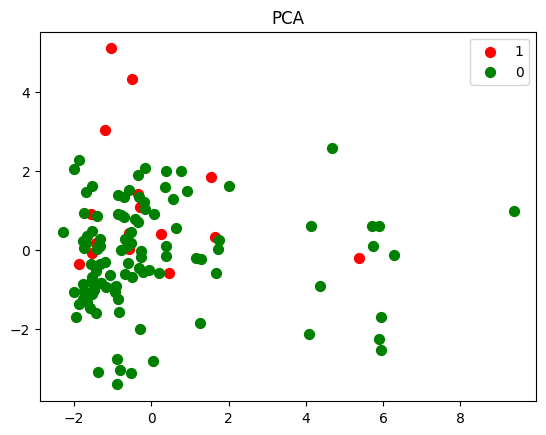

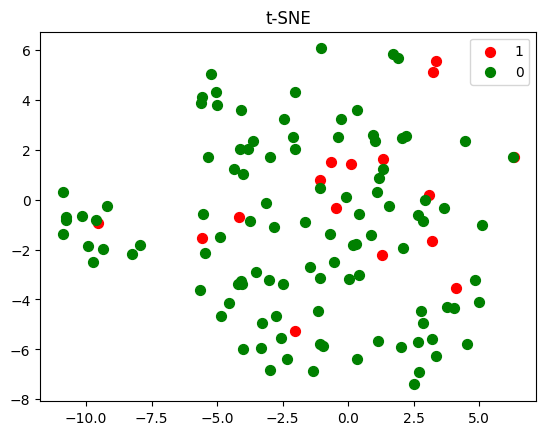

In [ ]:
# dimensionality reduction and pattern analysis
# PCA
from sklearn.decomposition import PCA
from pandas import DataFrame, concat

data = pd.read_csv("data/scaled_zscore.csv", sep=";")
features = data.drop(columns=['death_aecopd'])

X = np.asarray(features)
pca = PCA(n_components=2)
features_new = pca.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = data['death_aecopd'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('PCA')
plt.show()


# t-SNE
from sklearn.manifold import TSNE
from pandas import DataFrame, concat

data = pd.read_csv("data/scaled_zscore.csv", sep=";")
features = data.drop(columns=['death_aecopd'])

X = np.asarray(features)
tsne = TSNE(n_components=2)
features_new = tsne.fit_transform(X)

targets = [1, 0]
colors = ['r', 'g']

# create a scatterplot that shows whether each point belongs to class 1 or class 0 in 'death_aecopd'
for target, color in zip(targets,colors):
    indicesToKeep = data['death_aecopd'] == target
    plt.scatter(features_new[indicesToKeep, 0], features_new[indicesToKeep, 1], c = color, s = 50)
plt.legend(targets)
plt.title('t-SNE')
plt.show()


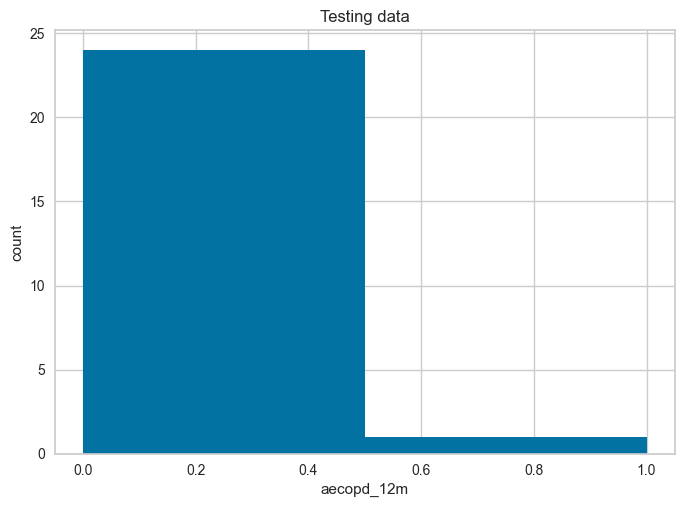

In [ ]:
# plot how often each class of the target variable (death_aecopd) appears in the original, training and testing dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# read in data
data = pd.read_csv('data/scaled_minmax.csv', sep=";",na_values=None, header=0)

# plot original data
plt.clf()
plt.title('Original data')
plt.xlabel('death_aecopd')
plt.ylabel('count')
plt.hist(data['death_aecopd'], bins=2)
plt.savefig('images/original_data.svg', format='svg', dpi=1200)

# split data into training and testing data
from sklearn.model_selection import train_test_split
X = data.drop(columns=['death_aecopd', "death", "aecopd_12m"])
y = data['aecopd_12m'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# plot training data
plt.clf()
plt.title('Training data')
plt.xlabel('aecopd_12m')
plt.ylabel('count')
plt.hist(y_train, bins=2)
plt.savefig('images/training_data.svg', format='svg', dpi=1200)

# plot testing data
plt.clf()
plt.title('Testing data')
plt.xlabel('aecopd_12m')
plt.ylabel('count')
plt.hist(y_test, bins=2)
plt.savefig('images/testing_data.svg', format='svg', dpi=1200)


In [112]:
# radviz feature visualization


from sklearn.naive_bayes import GaussianNB
from yellowbrick.features.radviz import RadViz 

# k fold cross validation for each naive bayes, decision tree and random forest classifier



# sex	season	aecopd_12m	saturation	rr	sbp	dbp	hr	temperature	oedema	retractions	confusion	dyspnoea_yesno	dyspnoea_mMRC	age	fev1	bmi	rural	home_care	charlson	ami	heart_failure	cbd	pad	dementia	diabetes	cancer

# rad viz plot
features = ["sex", "season", "saturation", "rr", "sbp", "dbp", "hr", "temperature", "oedema", "retractions", "confusion", "dyspnoea_yesno", "dyspnoea_mMRC", "age", "bmi", "rural", "home_care", "charlson", "ami", "heart_failure", "cbd", "pad", "dementia", "diabetes", "cancer"]
classes = []

X =  data[features]
y = data['aecopd_12m']

visualizer = RadViz(classes=classes, features=features)
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()


YellowbrickValueError: number of specified classes does not match number of unique values in target

<AxesSubplot: title={'center': 'Feature Importances of 22 Features using RandomForestClassifier'}, xlabel='relative importance'>

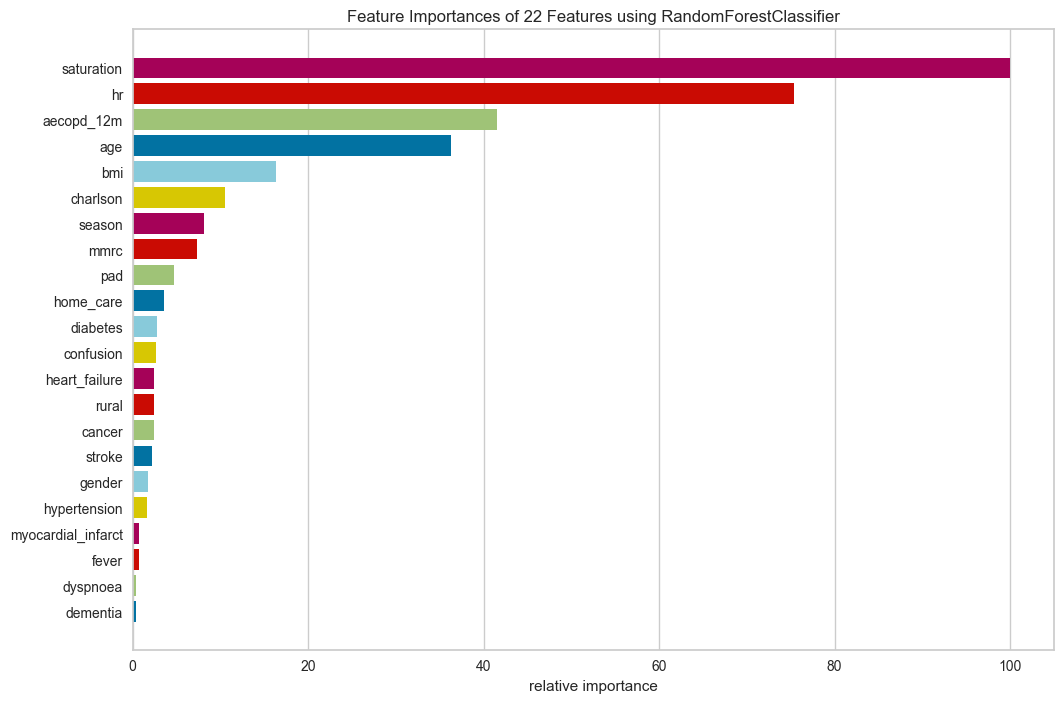

In [115]:
# feature importance of exaggerate dataset
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

X = exaggerate.drop(columns=['target'])
y = exaggerate['target']

viz = FeatureImportances(RandomForestClassifier(), size=(1080, 720))
viz.fit(X, y)


# save figure as svg
viz.poof(outpath="../plots/feature_importance_exaggerate.svg", dpi=1200)


In [11]:
# trying different classifiers

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# import decision tree, random forest and svm classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Define the classifiers you want to evaluate
classifiers = [DecisionTreeClassifier, RandomForestClassifier, SVC, GaussianNB, KNeighborsClassifier, MLPClassifier]

X = data.drop(columns=["aecopd_12m"])
y = data['aecopd_12m']

# Fold X 5 times
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# train and test each classifier
for classifier in classifiers:
    print("Classifier: ", classifier.__name__)
    accuracy = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = classifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
    print("Accuracy: ", accuracy)
    print("Mean accuracy: ", np.mean(accuracy))
    print("Standard deviation: ", np.std(accuracy))
    print("")

Classifier:  DecisionTreeClassifier
Accuracy:  [0.32599118942731276, 0.33480176211453744, 0.32599118942731276, 0.3788546255506608, 0.29646017699115046]
Mean accuracy:  0.3324197887021948
Standard deviation:  0.026599305713359767

Classifier:  RandomForestClassifier
Accuracy:  [0.3568281938325991, 0.42731277533039647, 0.3876651982378855, 0.4185022026431718, 0.38495575221238937]
Mean accuracy:  0.3950528244512884
Standard deviation:  0.02533072459725613

Classifier:  SVC
Accuracy:  [0.3744493392070485, 0.43171806167400884, 0.46255506607929514, 0.45374449339207046, 0.40707964601769914]
Mean accuracy:  0.4259093212740244
Standard deviation:  0.03210649563188371

Classifier:  GaussianNB
Accuracy:  [0.11013215859030837, 0.06167400881057269, 0.1013215859030837, 0.05726872246696035, 0.05752212389380531]
Mean accuracy:  0.07758371993294608
Standard deviation:  0.023199882782144996

Classifier:  KNeighborsClassifier
Accuracy:  [0.36123348017621143, 0.3436123348017621, 0.41409691629955947, 0.3964

# Benchmarking

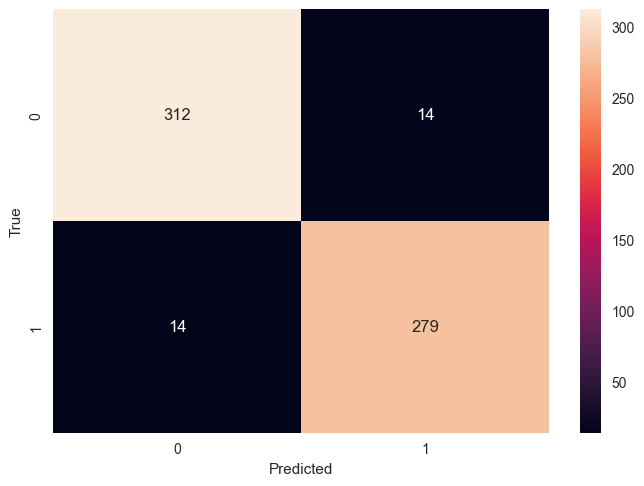

In [109]:
# fit a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = exaggerate.drop(columns=["target"])
y = exaggerate['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=10)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Index(['aecopd_12m', 'age', 'bmi', 'cancer', 'charlson', 'confusion',
       'dementia', 'diabetes', 'dyspnoea', 'fever', 'gender', 'heart_failure',
       'home_care', 'hr', 'hypertension', 'mmrc', 'myocardial_infarct', 'pad',
       'rural', 'saturation', 'season', 'stroke', 'target'],
      dtype='object')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9919224555735057


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9967689822294022


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9838449111470113


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9951534733441034


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9951456310679612


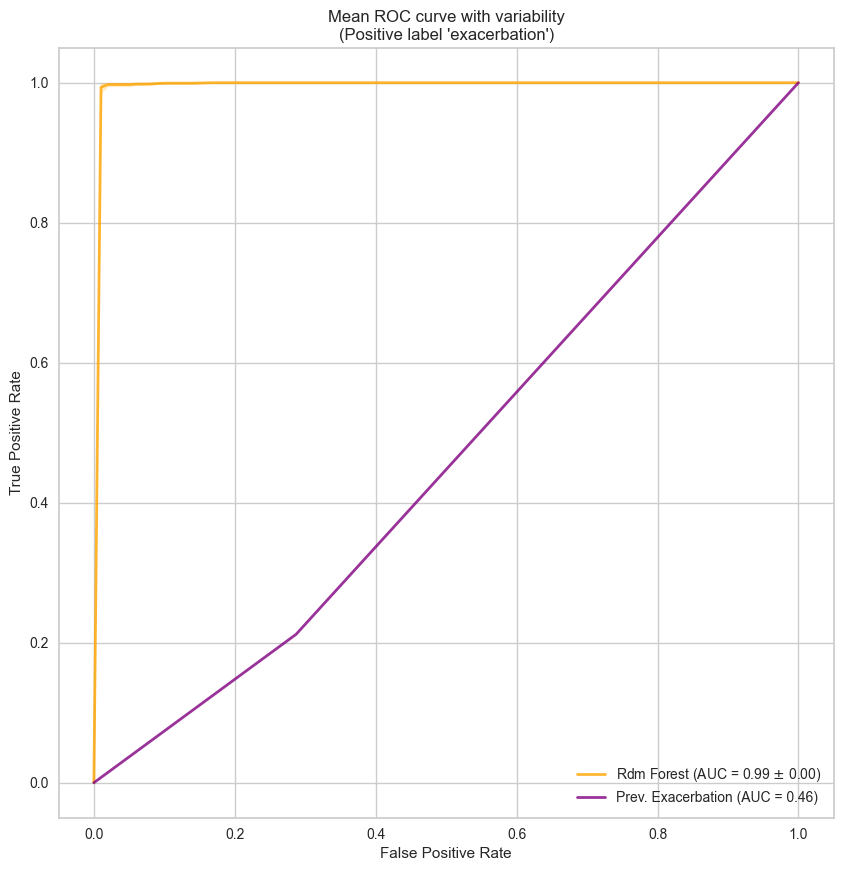

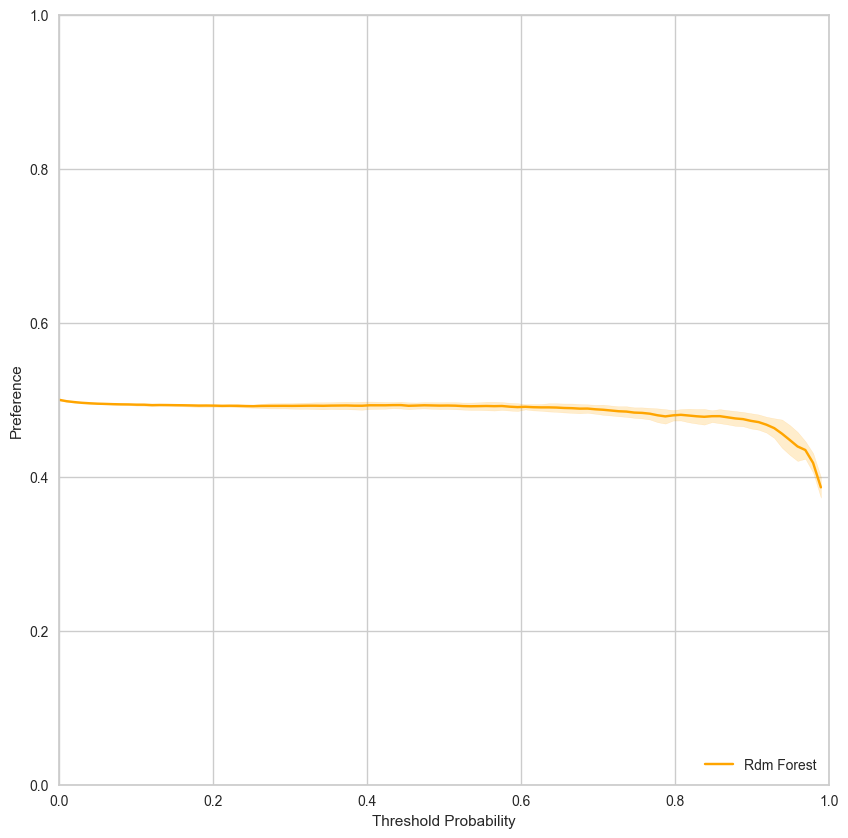

In [122]:
from sklearn.model_selection import StratifiedKFold
# import RocCurveDisplay to plot roc curves
from statkit.decision import NetBenefitDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

print(exaggerate.columns)

exaggerate_selection = exaggerate[exaggerate.columns]
X = exaggerate_selection.drop(columns=['target']).to_numpy()
# print(X.columns)
y = exaggerate_selection['target'].to_numpy()

fig, ax = plt.subplots(figsize=(10, 10))
fig2, ax2 = plt.subplots(figsize=(10, 10))

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
rf = RandomForestClassifier()
rf_tprs = []
rf_aucs = []
rf_mean_fpr = np.linspace(0, 1, 100)
# rf
for fold, (train, test) in enumerate(cv.split(X, y)):
    rf.fit(X[train], y[train])
    # do not display the plot in the legend
    rf_viz = RocCurveDisplay.from_estimator(
        rf,
        X[test],
        y[test],
        # name=f"Rdm. Forest",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    # hide the folds
    rf_viz.line_.set_visible(False)
    rf_viz.line_.set_label(None)
    # hide the legend handle for the folds
    rf_interp_tpr = np.interp(rf_mean_fpr, rf_viz.fpr, rf_viz.tpr)
    rf_interp_tpr[0] = 0.0
    rf_tprs.append(rf_interp_tpr)
    rf_aucs.append(rf_viz.roc_auc)
    y_pred = rf.predict_proba(X[test])[:, 1]
    # print accuracy
    print(f"Accuracy: {accuracy_score(y[test], y_pred.round())}")

    rf_nb = NetBenefitDisplay.from_predictions(y[test], y_pred, ax=ax2, benefit_type='action',  show_references=False)

# get the line data of the last 5 lines on the ax[1] plot
rf_nb_lines = ax2.get_lines()[-5:]
# remove these lines from the plot
for line in rf_nb_lines:
    line.remove()

# limit all lines to length 90
for line in rf_nb_lines:
    # get the x data
    line.set_data(line.get_xdata()[:99], line.get_ydata()[:99])
# calculate the mean of the lines and disregard different lengths
rf_nb_mean = np.mean([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# calculate the std of the lines
rf_nb_std = np.std([rf_nb_lines[i].get_xydata() for i in range(len(rf_nb_lines))], axis=0)
# plot the mean and std
ax2.plot(rf_nb_mean[:, 0], rf_nb_mean[:, 1], color="orange", label=r"Rdm Forest")
ax2.fill_between(
    rf_nb_mean[:, 0],
    rf_nb_mean[:, 1] - rf_nb_std[:, 1],
    rf_nb_mean[:, 1] + rf_nb_std[:, 1],
    alpha=0.2,
    color="orange",
)

rf_mean_tpr = np.mean(rf_tprs, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(rf_mean_fpr, rf_mean_tpr)
rf_std_auc = np.std(rf_aucs)
ax.plot(
    rf_mean_fpr,
    rf_mean_tpr,
    color="orange",
    label=r"Rdm Forest (AUC = %0.2f $\pm$ %0.2f)" % (rf_mean_auc, rf_std_auc),
    lw=2,
    alpha=0.8,
)

rf_std_tpr = np.std(rf_tprs, axis=0)
rf_tprs_upper = np.minimum(rf_mean_tpr + rf_std_tpr, 1)
rf_tprs_lower = np.maximum(rf_mean_tpr - rf_std_tpr, 0)
ax.fill_between(
    rf_mean_fpr,
    rf_tprs_lower,
    rf_tprs_upper,
    color="orange",
    alpha=0.2,
    # label=r"$\pm$ 1 std. dev.",
    label = None
)

# previous exacerbation alone
y_pred_prev_ex = np.where(exaggerate['aecopd_12m'] == 1, 1, 0)
prev_exa_fpr, prev_exa_tpr, prev_exa_thresholds = roc_curve(exaggerate['target'], y_pred_prev_ex)
prev_exa_auc = auc(prev_exa_fpr, prev_exa_tpr)
ax.plot(
    prev_exa_fpr,
    prev_exa_tpr,
    color="purple",
    label=r"Prev. Exacerbation (AUC = %0.2f)" % (prev_exa_auc),
    lw=2,
    alpha=0.8,
)

# ADO

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'exacerbation')",
)

ax2.set(
    xlim=[0, 1],
    ylim=[0, 1],
    xlabel="Threshold Probability",
    ylabel="Preference",
    title=f"",
)

plt.gca().set_aspect('equal')
ax.legend(loc="lower right")
ax2.legend(loc="lower right")
plt.show()

In [ ]:
# confusion matrix

from numpy import ndarray
from sklearn.metrics import confusion_matrix

labels: ndarray = np.unique(y)
labels.sort()
prdY: ndarray = clf.predict(X_test)
cnf_mtx_tst: ndarray = confusion_matrix(y_test, prdY, labels=labels)
cnf_mtx_tst

import itertools
import matplotlib.pyplot as plt
CMAP = plt.cm.Blues

def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray, ax: plt.Axes = None,
                          normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='y', horizontalalignment="center")

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[0,0])
plot_confusion_matrix(cnf_mtx_tst, labels, axs[0,1], normalize=True)
plt.show()

In [ ]:
# ROC curve

data = pd.read_csv('data/scaled_zscore.csv', sep=";",na_values=None, header=0)

y = data.pop('death_aecopd').values
X = data.values
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
model = GaussianNB().fit(trnX, trnY)

# plot roc curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# predict probabilities
lr_probs = model.predict_proba(tstX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(tstY, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(tstY, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

NameError: name 'pd' is not defined